Team,

I've produced clean data for folks to work with downstream, and provided some preliminary sketches of how the data can be used.  Scan thru the notebook to see what the dataframes look like....

<b>youtube_data</b>: US data downloaded from youtube and cleaned<br><br>
<b>pub_by_date</b>: Videos published by date.  I made a line graph. I can also group them by day of week if you'd like.<br><br>
<b>categories</b>: Vids grouped by category with number, likes and dislikes.  Can make plots / inferences.<br><br>
<b>month_stats</b>: Data by months--published, trending, views<br><br>
<b>lag_data</b>: days it takes videos to trend.  Nice histogram with single outlier that we could find and remove.

I've also done the user input thing at the end.

Most of the work was brute-force data cleaning, and therefore not very interesting.  However, some learning:

<i>1) The datetime type allows you to manipulate dates with ease.  Not covered in class but powerful.  See the description in cell In[4].</i><br><br>
<i>2) Lots of duplicate videos.  Folks post the same video multiple times from the same account.  Dropped these.  If I want to be more sophisticated, I'd loop thru videos by name, and total all of the video statistics for all repeats.  Maybe will do that this week to further clean up the data.</i>

Let me know if there is other data you'd like me to produce.  I'll start helping with the MatPlotLib and API folks now.

--Tom


In [1]:
# Load packages
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import functools as ft

In [2]:
# Load data
youtube_data = pd.read_csv('US_youtube_trending_data.csv')
lookup = pd.read_csv('category_ids.csv')


In [3]:
# Function to parse dates (there is probably a built-in function, but this is what I was able to figure out)

def youtube_date_parse(df, series_to_parse, new_name_date, new_name_time, delimiting_character, drop_character):
    try:
        split = df[series_to_parse].str.split(delimiting_character, n = 1, expand = True)
        split[1] =split[1].map(lambda x: x.rstrip(drop_character))
        df[new_name_date] = split[0]
        df[new_name_time] = split[1]
        df.drop(columns = [series_to_parse], inplace=True)
        df[new_name_date] = pd.to_datetime(df[new_name_date])
        return df
    except:
        print('Already parsed, dumbass...')
        
        

In [4]:
########### Clean up data: drop columns, parse dates, replace category numbers with cateogry names, etc. #####

# Drop unneeded columns
youtube_data.drop(['video_id','channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'],\
                  axis=1, inplace = True)

# Convert date strings to datetime objects
youtube_date_parse(youtube_data, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')
youtube_date_parse(youtube_data, 'trending_date', 'date_trending', 'time_trending', 'T', 'Z')
youtube_data.drop(['time_trending'], axis=1, inplace=True)

# The datetime functions are great, and can be used to group (see below).
# To make life easier for folks, I'm going to put month names in their own column
# notice the .dt.month syntax that works on datetime objects
youtube_data['month_published']= youtube_data['date_published'].dt.month
youtube_data['month_trending'] = youtube_data['date_trending'].dt.month
youtube_data['month_published'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)
youtube_data['month_trending'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)

# Calculate lag time between posting and trending.  You can do arithmetic with dates in datetime
youtube_data['lag'] = youtube_data['date_trending'] - youtube_data['date_published']

# Covert category IDs to catetory names
youtube_data['categoryId'].replace(lookup['categoryId'].tolist(), lookup['category'].tolist(), inplace=True)

# Rename columns
new_names = {'channelTitle':'channel', 'categoryId':'category', 'view_count':'views', 'comment_count':'comments'}
youtube_data.rename(columns = new_names, inplace=True)

# Sort by likes
youtube_data.sort_values('likes', ascending=False, inplace=True)


# Reorder columns for readability
new_order = ['channel', 'title', 'category', 'views', 'likes','dislikes','comments', 'date_published', 'date_trending','lag','month_published', 'month_trending', 'time_published','tags', 'description']
youtube_data=youtube_data[new_order]

# Get column names so they are handy
cols = youtube_data.columns

# Keep only the most popular posting of duplicate videos
# I could maybe try to roll the stats for duplicates together,
# but this is tricky, in that they will have different dates.
youtube_data = youtube_data.drop_duplicates(subset='title', keep='first')
youtube_data


,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK – ‘Lovesick Girls’ M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14402,Kylie Jenner,Rating My Halloween Costumes,People & Blogs,2865810,0,0,8365,2020-10-22,2020-10-23,1 days,Oct,Oct,21:54:45,[None],I'm going through my favorite Halloween costum...
7659,Kylie Jenner,What's In My Bag,People & Blogs,3623458,0,0,20067,2020-09-15,2020-09-19,4 days,Sept,Sept,19:59:14,Kylie Jenner|what's in my bag|vlog|kylie|kylie...,It’s been almost two years since I did my last...
7691,Nissan,Introducing the Nissan Z Proto,Autos & Vehicles,678050,0,0,7772,2020-09-16,2020-09-19,3 days,Sept,Sept,00:45:01,Nissan|Nissan Motor|Nissan Intelligent Mobilit...,Taking inspiration from 50 years of innovation...
7724,Governor Andrew M. Cuomo,Certified Young Person Paul Rudd Wants You To ...,News & Politics,1273868,0,0,0,2020-09-14,2020-09-19,5 days,Sept,Sept,19:54:46,New York State|Governor Andrew Cuomo|Paul Rudd...,Governor Cuomo asked 26-year-old actor Paul Ru...


In [5]:
# See how many videos were published each day in the dataset
# Remember, the youtube data set is a subset of of trending videos in the US, not all videos
pub_by_date = youtube_data[['title', 'date_published']].groupby('date_published')\
.count().rename(columns={'title':'number_published'})
pub_by_date

,number_published
date_published,
2020-08-03,1
2020-08-05,4
2020-08-06,22
2020-08-07,34
2020-08-08,29
...,...
2020-11-01,27
2020-11-02,38
2020-11-03,13


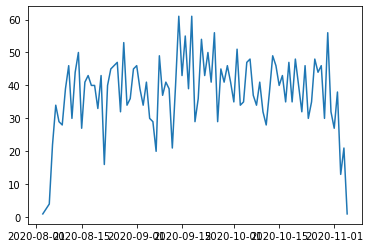

In [6]:
# And plot the number published each day
# I could see if there are trends by days of the week
plt.plot(pub_by_date['number_published'])

In [7]:
# Categories looks at total published, likes, and dislikes.
# Only the news and politics have significant dislikes
categories = youtube_data[['category', 'title']].groupby('category').count().rename(columns={'title':'number_published'}).sort_values('number_published', ascending=False)


categories['likes'] = youtube_data[['category', 'likes']].groupby('category').sum()
categories['dislikes'] = youtube_data[['category', 'dislikes']].groupby('category').sum()
#opinions = pd.merge(likes, dislikes, on="category")

categories['total_opinions'] = categories['likes'] + categories['dislikes'] 
categories['% like'] = (categories['likes'] / categories['total_opinions']).map("{:.2%}".format)
categories['% dislike'] = (categories['dislikes'] / categories['total_opinions']).map("{:.2%}".format)

print('categories:')
categories

categories:


,number_published,likes,dislikes,total_opinions,% like,% dislike
category,,,,,,
Music,801,254239406,6688126,260927532,97.44%,2.56%
Entertainment,657,103303685,2091086,105394771,98.02%,1.98%
Sports,504,15862292,569669,16431961,96.53%,3.47%
Gaming,317,47113552,1322594,48436146,97.27%,2.73%
People & Blogs,273,36294827,1085630,37380457,97.10%,2.90%
Comedy,212,29566307,340045,29906352,98.86%,1.14%
Science & Technology,180,15725993,597019,16323012,96.34%,3.66%
News & Politics,158,3223871,556373,3780244,85.28%,14.72%
Howto & Style,151,11417546,347035,11764581,97.05%,2.95%


<BarContainer object of 15 artists>

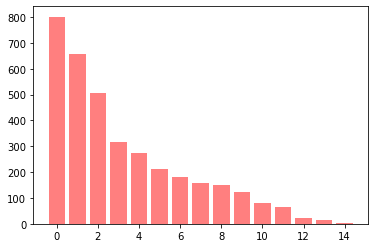

In [8]:
# Plot number of vids in each category
# Someone could add the x labels.  I'm bad at it.
x_axis = np.arange(len(categories))
y_axis = categories['number_published']
plt.bar(x_axis, y_axis, color='r', alpha=0.5, align="center")

In [9]:
# See if there are any trends by month.
# There are not.

month_stats = youtube_data[['date_published', 'title']].groupby(pd.Grouper(key='date_published',freq='M')).count()\
.rename(columns={'title':'published'})
month_stats['trending'] = youtube_data[['date_trending', 'title']].groupby(pd.Grouper(key='date_trending',freq='M')).count()
month_stats['views'] = youtube_data[['date_published', 'views']].groupby(pd.Grouper(key='date_published',freq='M')).sum()
print('month_stats:')
month_stats.set_index(pd.Index(['Aug', 'Sept', 'Oct', 'Nov']))

month_stats:


,published,trending,views
Aug,988,783,2942488874
Sept,1236,1221,3239138144
Oct,1242,1239,3753111791
Nov,100,323,172017030


(array([8.13236119e-03, 2.77621985e-02, 1.79472799e-02, 4.40269209e-02,
        1.09366237e-01, 2.83510937e-01, 3.31744251e-01, 1.44699944e-01,
        2.74817723e-02, 3.08468873e-03, 2.80426248e-04, 0.00000000e+00,
        2.80426248e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.80426248e-04, 0.00000000e+00,
        2.80426248e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.80426248e-04, 8.41278744e-04]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30.]),
 <a list of 30 Patch objects>)

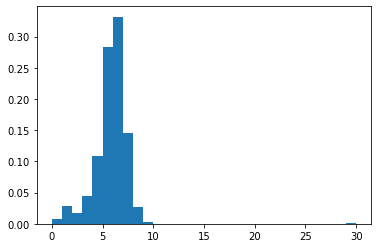

In [10]:
# See how long it takes a video to trend.
# We have a single outlier at 30 days, which we could chop off in subsequent work.

lag_data = youtube_data['lag'].dt.days
plt.hist(lag_data, density=True, bins=30)

In [ ]:
# Produce the most popular videos for a user

answer = 'Y'
while answer == 'Y':
    month = input('\n\nMonth for most liked videos (Aug, Sept, Oct, Nov)?')
    number = int(input('How many videos to see?'))
    month_data = youtube_data.loc[youtube_data['month_published']==month]
    month_sorted = month_data.sort_values('likes', ascending=False)
    print('Most popular videos:')
    vids = month_sorted.iloc[0:number,:]
    print(vids['title'])
    answer = input('Continue Y/N?')



Month for most liked videos (Aug, Sept, Oct, Nov)?Aug
How many videos to see?5
Most popular videos:
3358                   BTS (방탄소년단) 'Dynamite' Official MV
4980      BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V
2762               BTS (방탄소년단) 'Dynamite' Official Teaser
3992          BTS (방탄소년단) 'Dynamite' Official MV (B-side)
985     Cardi B - WAP feat. Megan Thee Stallion [Offic...
Name: title, dtype: object
Continue Y/N?Y


Month for most liked videos (Aug, Sept, Oct, Nov)?Oct
How many videos to see?12
Most popular videos:
11764                     BLACKPINK – ‘Lovesick Girls’ M/V
11786    BTS (방탄소년단) 'Savage Love' (Laxed – Siren Beat)...
15557           Ariana Grande - positions (official video)
16382               Harry Styles - Golden (Official Video)
12788    BLACKPINK - 'Lovesick Girls' DANCE PRACTICE VIDEO
16161                            TWICE I CAN'T STOP ME M/V
12196                                     Hi Me In 5 Years
13186                      AMONG US, but with 99 I